In [432]:
import torch
import torch.nn.functional as F
from helper import *

In [433]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [434]:
words = read_words('names.txt')
stoi, itos = get_mapping(words)
nchars = len(stoi.keys())


In [435]:
train_split, val_split = 0.8, 0.1
X, Y = build_dataset(words, stoi, block_size=3)
X, Y = torch.tensor(X), torch.tensor(Y)


n = len(X)
n1 = round(n * train_split)
n2 = round(n * val_split)


X_train, Y_train = X[:n1], Y[:n1]
X_val, Y_val = X[n1:n1+n2], Y[n1:n1+n2]
X_test, Y_test = X[n1+n2:], Y[n1+n2:]

In [707]:
class Linear:
    def __init__(self, fan_in, fan_out, b = None):
        self.W = torch.ones(fan_in, fan_out)
        self.b = None
        if b is not None:
            self.b = torch.zeros(fan_out)

    def __call__(self, x):
        out = x @ self.W
        if self.b is not None:
            out = out + self.b
        self.out = out
        return out
    
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])
    

class LinearBatchNorm1d:
    def __init__(self, fan_in, fan_out):
        self.Training = True
        self.Folding = True
        self.linear = Linear(fan_in, fan_out, False)
        self.bn = BatchNorm1d(fan_out)
        self.W_folded = None
        self.b_folded = None

    def __call__(self, x):
        if self.Training or not self.Folding:
            x = self.linear(x)
            out = self.bn(x)
        else:
            if self.W_folded is None:
                self.W_folded = self.bn.gamma * self.linear.W / (torch.sqrt(self.bn.running_var + self.bn.epsilon))
                self.b_folded = self.bn.beta
                print("test")
            out = x @ self.W_folded + self.b_folded
            
        return out
    
    def setTraining(self, train):
        self.Training = train
        self.bn.Training = train
        if train:
            self.W_folded = None
            self.b_folded = None

    def parameters(self):
        return self.linear.parameters() + self.bn.parameters()
    
    

class Tanh:
    def __call__(self, x):
        out = torch.tanh(x)
        self.out = out
        return out
    
    def parameters(self):
        return []
    
class BatchNorm1d:
    def __init__(self, hidden_dim, epsilon = 1e-7, momentum = 0.99):
        self.Training = True
        self.gamma = torch.ones(hidden_dim)
        self.beta = torch.zeros(hidden_dim)
        self.running_mean = torch.zeros((1, hidden_dim))
        self.running_var = torch.ones((1, hidden_dim))
        self.epsilon = epsilon
        self.momentum = momentum

    def __call__(self, x):
        if self.Training:
            mean = x.mean(0, keepdim = True)
            var = x.var(0, keepdim = True)
        else:
            mean = self.running_mean
            var = self.running_var

        x_gaus = (x - mean) / torch.sqrt(var + self.epsilon)
        out = (self.gamma * x_gaus) + self.beta

        if self.Training:
            with torch.no_grad():
                self.running_mean = self.running_mean * self.momentum + (1 - self.momentum) * mean
                self.running_var = self.running_var * self.momentum + (1 - self.momentum) * var

        self.out = out
        return out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Embedding:
    def __init__(self, num_class, emb_dim):
        self.C = torch.randn(num_class, emb_dim)


    def __call__(self, x):
        out = self.C[x]
        self.out = out
        return out
    
    def parameters(self):
        return [self.C]
    
class Flatten:
    def __call__(self, x):
        N, T, C = x.shape
        out = x.view(N, T*C)
        self.out = out
        return out
    
    def parameters(self):
        return []
    

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        p = []
        for layer in self.layers:
            p = p + layer.parameters()
        return p

In [662]:
emb_dim = 10
block_size = 3
hidden_dim = 100

In [698]:
layers = Sequential([
    Embedding(nchars, emb_dim),
    Flatten(),
    Linear(block_size * emb_dim, hidden_dim, b = False), Tanh(),
    Linear(hidden_dim, hidden_dim, b = False), Tanh(),
    Linear(hidden_dim, hidden_dim, b = False), Tanh(),
    Linear(hidden_dim, hidden_dim, b = False), Tanh(),
    Linear(hidden_dim, nchars, b = False)
])

for p in layers.parameters():
    p.requires_grad = True

In [699]:
logits = layers(X_train)

loss = F.cross_entropy(logits, Y_train)

logits.retain_grad()

loss.backward()

In [700]:
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
X_train[0]

tensor([0, 0, 0])

torch.Size([100])
layer 3 (      Tanh): mean +0.06, std 0.92, saturated: 71.45%
torch.Size([100])
layer 5 (      Tanh): mean +0.05, std 1.00, saturated: 99.89%
torch.Size([100])
layer 7 (      Tanh): mean +0.05, std 1.00, saturated: 100.00%
torch.Size([100])
layer 9 (      Tanh): mean +0.05, std 1.00, saturated: 100.00%


Text(0.5, 1.0, 'activation distribution')

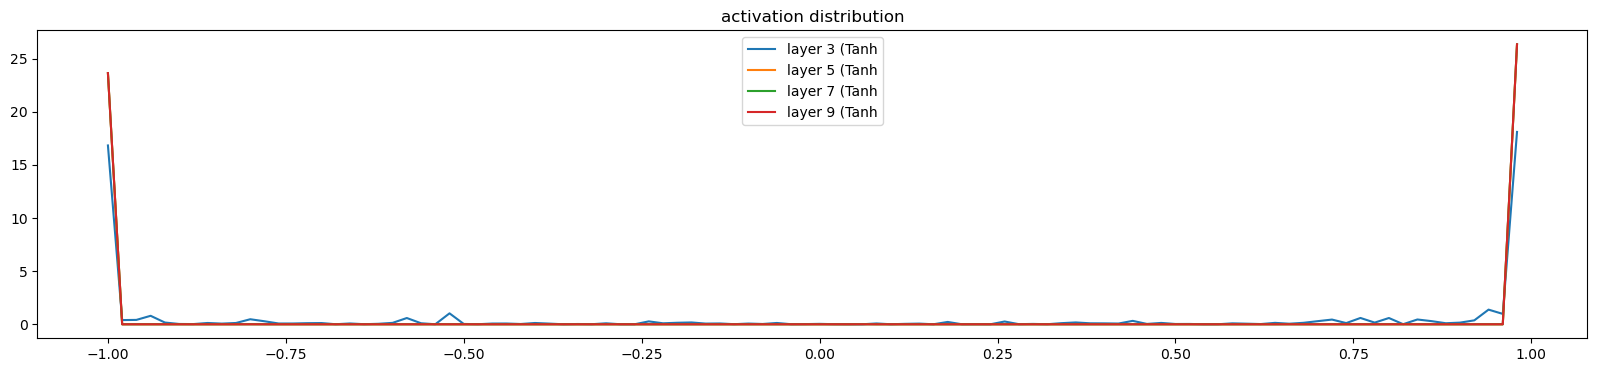

In [701]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print(t[0].shape)
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')



In [667]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers.layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
        if i == 10:
            #print((logits.grad @ layer.W.T).std())
            pass
plt.legend(legends)
plt.title('gradient distribution')

/var/folders/nd/_xpmwfn50nb97kqnlvcpty9w0000gn/T/ipykernel_37815/1063832456.py:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  t = layer.out.grad


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

### TEST

In [702]:
model = Sequential([
    Embedding(nchars, emb_dim),
    Flatten(),
    LinearBatchNorm1d(block_size * emb_dim, hidden_dim), Tanh(),
    LinearBatchNorm1d(hidden_dim, hidden_dim), Tanh(),
    LinearBatchNorm1d(hidden_dim, hidden_dim), Tanh(),
    LinearBatchNorm1d(hidden_dim, hidden_dim), Tanh(),
    Linear(hidden_dim, nchars, b = False)
])

for p in model.parameters():
    p.requires_grad = True

In [703]:
iterations = 10000
lr = 0.1
reg  = 0.01
batch_size = 64


stepi = []
lossi = []

for k in range(iterations):
    for p in model.parameters():
        p.grad = None

    idx = torch.randint(0, X_train.shape[0], (batch_size,))
    logits = model(X_train[idx])

    loss = F.cross_entropy(logits, Y_train[idx])

    loss.backward()

    for p in model.parameters():
        p.data -= lr * p.grad
    stepi.append(k)
    lossi.append(loss.item())

    pred = logits.argmax(dim = 1)
    acc = (pred == Y_train[idx]).float().mean().data
    print(f"iteration {k} loss {loss.data}, acc {acc * 100}")

iteration 0 loss 3.295837163925171, acc 17.1875
iteration 1 loss 3.289222478866577, acc 14.0625
iteration 2 loss 3.2533953189849854, acc 18.75
iteration 3 loss 3.207397699356079, acc 6.25
iteration 4 loss 3.3675360679626465, acc 17.1875
iteration 5 loss 3.2205169200897217, acc 14.0625
iteration 6 loss 3.2628350257873535, acc 3.125
iteration 7 loss 3.304940700531006, acc 4.6875
iteration 8 loss 3.281834602355957, acc 10.9375
iteration 9 loss 3.237934112548828, acc 14.0625
iteration 10 loss 3.2235872745513916, acc 18.75
iteration 11 loss 3.224116563796997, acc 20.3125
iteration 12 loss 3.2382009029388428, acc 20.3125
iteration 13 loss 3.3018176555633545, acc 14.0625
iteration 14 loss 3.152125597000122, acc 25.0
iteration 15 loss 3.2730894088745117, acc 17.1875
iteration 16 loss 3.2990596294403076, acc 12.5
iteration 17 loss 3.1330246925354004, acc 20.3125
iteration 18 loss 3.2255256175994873, acc 6.25
iteration 19 loss 3.0995614528656006, acc 25.0
iteration 20 loss 3.181182861328125, acc

In [716]:
x = model(X_train)
model.layers[2].setTraining(False)
model.layers[2].Folding = True

model.layers[4].setTraining(False)
model.layers[4].Folding = True

model.layers[6].setTraining(False)
model.layers[6].Folding = True

model.layers[8].setTraining(False)
model.layers[8].Folding = True


torch.allclose(model(X_train), x)


True

In [679]:
#model2(X_train)
model.layers[3].Training = False
model.layers[6].Training = False
model.layers[9].Training = False
model.layers[12].Training = False
model(X_train)

tensor([[-79.6805, -73.8564, -75.5004,  ..., -77.7164, -75.3075, -75.8941],
        [-77.8611, -72.1248, -73.7959,  ..., -75.9888, -73.5700, -74.1813],
        [-63.4256, -58.3874, -60.2727,  ..., -62.2816, -59.7854, -60.5923],
        ...,
        [ 61.1063,  60.1216,  56.3878,  ...,  55.9667,  59.1320,  56.6361],
        [-79.6805, -73.8564, -75.5004,  ..., -77.7164, -75.3075, -75.8941],
        [-68.3681, -63.0909, -64.9028,  ..., -66.9748, -64.5051, -65.2451]],
       grad_fn=<AddBackward0>)

In [ ]:
x = torch.tensor([0.5, 0.2, 0.3])
y = torch.tensor([2])

layers = Sequential([
    Embedding(nchars, emb_dim),
    Flatten(),
    Linear(block_size*emb_dim, hidden_dim),
    Linear(hidden_dim, hidden_dim)
])

for p in layers.parameters():
    p.requires_grad = True

In [553]:
(logits.grad @ layers.layers[-1].W.T).shape

torch.Size([182517, 100])

In [376]:
X_train[0].shape, Y_train[0]

(torch.Size([3]), tensor(5))

In [377]:
logits = layers(X_train[0][None, :])
print(logits)
loss = F.cross_entropy(logits, Y_train[0][None])
loss

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], grad_fn=<MmBackward0>)


tensor(3.2958, grad_fn=<NllLossBackward0>)

In [378]:
loss.backward()

In [379]:
print(layers.parameters()[0].shape)
#print(layers.parameters()[0].grad)

torch.Size([27, 10])


In [380]:
x = torch.tensor([[0.8, 0.2]])
y = torch.tensor([1])

layers = Sequential([
    Linear(3, 2),
])

for p in layers.parameters():
    p.requires_grad = True

logits = layers(x)

loss = F.cross_entropy(logits, y)
loss.backward()


print(loss)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 3x2)

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time

model = Sequential([
    Linear(2, 2)
])

for p in model.parameters():
    p.requires_grad = True

y = torch.randint(0, 2,(40000, 2)).float()
for _ in range(10000):
    # Create a meshgrid of points
    x_min, x_max = -1, 2
    y_min, y_max = -1, 2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    # Get model predictions
    logits = model(grid)
    preds = torch.argmax(logits, dim=1).numpy()

    # Plot
    plt.contourf(xx, yy, preds.reshape(xx.shape), alpha=0.5, cmap='coolwarm')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Decision Boundary")
    plt.legend()
    plt.show()


    for p in model.parameters():
        p.grad = None

    print(logits.shape)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    print(loss.item())

    for p in model.parameters():
        p.data -= 0.1 * p.grad
    print(p.grad)

In [ ]:
Linear(2, 2)

### 1-Layer with 0 init

In [404]:
input = torch.tensor([[1.0,2.0,3.0],  [4.0,5.0,6.0]])
truth = torch.tensor([1, 2])
W = torch.zeros(((3,3)))
b = torch.zeros((3))

input.requires_grad = True
W.requires_grad = True
b.requires_grad = True

logits = input @ W + b

logits.retain_grad()
loss = F.cross_entropy(logits, truth)

loss


tensor(1.0986, grad_fn=<NllLossBackward0>)

In [405]:
loss.backward()

In [ ]:
print(W.grad) 
# input.T @ dlogits
# 1 4       0.1667 -0.333 0.1667
# 2 5   x   0.1667 0.1667 -0.333
# 3 6
print(b.grad)
# dlogits.sum(0)

print(input.grad)
# dlogits @ W.T
# 0.1667 -0.333 0.1667      0 0 0 
# 0.1667 0.1667 -0.333   x  0 0 0 
#                           0 0 0
print(logits.grad)


tensor([[ 8.3333e-01,  3.3333e-01, -1.1667e+00],
        [ 1.1667e+00,  1.6667e-01, -1.3333e+00],
        [ 1.5000e+00, -5.9605e-08, -1.5000e+00]])
tensor([ 0.3333, -0.1667, -0.1667])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[ 0.1667, -0.3333,  0.1667],
        [ 0.1667,  0.1667, -0.3333]])


### 1-Layer with constant (1) init

In [408]:
input = torch.tensor([[1.0,2.0,3.0],  [4.0,5.0,6.0]])
truth = torch.tensor([1, 2])
W = torch.ones(((3,3)))
b = torch.zeros((3))

input.requires_grad = True
W.requires_grad = True
b.requires_grad = True

logits = input @ W + b

logits.retain_grad()
loss = F.cross_entropy(logits, truth)

loss


tensor(1.0986, grad_fn=<NllLossBackward0>)

In [409]:
loss.backward()

In [ ]:
print(W.grad) 
# input.T @ dlogits
# 1 4       0.1667 -0.333 0.1667
# 2 5   x   0.1667 0.1667 -0.333
# 3 6
print(b.grad)
# dlogits.sum(0)

print(input.grad)
# dlogits @ W.T

# 0.1667 -0.333 0.1667      1 1 1
# 0.1667 0.1667 -0.333   x  1 1 1
#                           1 1 1
print(logits.grad)


## Zero grad for the input when using crossentropy

tensor([[ 8.3333e-01,  3.3333e-01, -1.1667e+00],
        [ 1.1667e+00,  1.6667e-01, -1.3333e+00],
        [ 1.5000e+00, -5.9605e-08, -1.5000e+00]])
tensor([ 0.3333, -0.1667, -0.1667])
tensor([[-2.9802e-08, -2.9802e-08, -2.9802e-08],
        [-2.9802e-08, -2.9802e-08, -2.9802e-08]])
tensor([[ 0.1667, -0.3333,  0.1667],
        [ 0.1667,  0.1667, -0.3333]])


tensor([[ 0.1667, -0.3333,  0.1667],
        [ 0.1667,  0.1667, -0.3333]])

### 2-Layer with zero init

In [ ]:
input = torch.tensor([[1.0,2.0,3.0],  [4.0,5.0,6.0]])
truth = torch.tensor([1, 2])
W1 = torch.zeros(((3,3)))
b1 = torch.zeros((3))
W2 = torch.zeros(((3,3)))
b2 = torch.zeros((3))
W1.requires_grad = True
b1.requires_grad = True
W2.requires_grad = True
b2.requires_grad = True


h = input @ W1 + b1
logits = h @ W2 + b2

logits.retain_grad()
h.retain_grad()
loss = F.cross_entropy(logits, truth)

loss


tensor(1.0986, grad_fn=<NllLossBackward0>)

In [419]:
loss.backward()

In [ ]:
print(logits.grad)

print(W2.grad)
# h.T @ dlogits
# 0 0       0.1667 -0.333 0.1667
# 0 0   x   0.1667 0.1667 -0.333
# 0 0
print(b2.grad)
# dlogits.sum(0)

print(h.grad)
# dlogits @ W2.T
# 0.1667 -0.333 0.1667      0 0 0
# 0.1667 0.1667 -0.333   x  0 0 0
#                           0 0 0


print(W1.grad)
# input.T @ dh
# 1 4       0.0 0.0 0.0
# 2 5   x   0.0 0.0 0.0  = 
# 3 6

print(b1.grad)
# dlogits.sum(0) = 0


## Zero grad 

tensor([[ 0.1667, -0.3333,  0.1667],
        [ 0.1667,  0.1667, -0.3333]])
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([ 0.3333, -0.1667, -0.1667])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0., 0.])


### 2-Layer with constant (1) init

In [426]:
input = torch.tensor([[1.0,2.0,3.0],  [4.0,5.0,6.0]])
truth = torch.tensor([1, 2])
W1 = torch.ones(((3,3)))
b1 = torch.zeros((3))
W2 = torch.ones(((3,3)))
b2 = torch.zeros((3))
W1.requires_grad = True
b1.requires_grad = True
W2.requires_grad = True
b2.requires_grad = True


h = input @ W1 + b1
logits = h @ W2 + b2

logits.retain_grad()
h.retain_grad()
loss = F.cross_entropy(logits, truth)

loss


tensor(1.0986, grad_fn=<NllLossBackward0>)

In [427]:
loss.backward()

In [430]:
logits.grad

tensor([[ 0.1667, -0.3333,  0.1667],
        [ 0.1667,  0.1667, -0.3333]])

In [ ]:
print(logits.grad)
print(W2.grad)
# h.T @ dlogits
# 6 15       0.1667 -0.333 0.1667
# 6 15   x   0.1667 0.1667 -0.333
# 6 15
print(b2.grad)
# dlogits.sum(0)

print(h.grad)
# dlogits @ W2.T
# 0.1667 -0.333 0.1667      1 1 1
# 0.1667 0.1667 -0.333   x  1 1 1
#                           1 1 1

## Zero grad for the input when using crossentropy

print(W1.grad)
# input.T @ dh
# 1 4       0.0 0.0 0.0
# 2 5   x   0.0 0.0 0.0  = 
# 3 6

print(b1.grad)
# dlogits.sum(0) = 0



tensor([[ 0.1667, -0.3333,  0.1667],
        [ 0.1667,  0.1667, -0.3333]])
tensor([[ 3.5000,  0.5000, -4.0000],
        [ 3.5000,  0.5000, -4.0000],
        [ 3.5000,  0.5000, -4.0000]], grad_fn=<MmBackward0>)
tensor([[ 3.5000,  0.5000, -4.0000],
        [ 3.5000,  0.5000, -4.0000],
        [ 3.5000,  0.5000, -4.0000]])
tensor([ 0.3333, -0.1667, -0.1667])
tensor([[-2.9802e-08, -2.9802e-08, -2.9802e-08],
        [-2.9802e-08, -2.9802e-08, -2.9802e-08]])
tensor([[-1.4901e-07, -1.4901e-07, -1.4901e-07],
        [-2.0862e-07, -2.0862e-07, -2.0862e-07],
        [-2.6822e-07, -2.6822e-07, -2.6822e-07]])
tensor([-5.9605e-08, -5.9605e-08, -5.9605e-08])


dL/a^l * (da^l / dz^l) * (dz^l / dWl)

In [ ]:



# aL

In [396]:
logits.grad #why not divde by 2?

tensor([[ 0.1667, -0.3333,  0.1667],
        [ 0.1667,  0.1667, -0.3333]])

In [398]:
logits.grad
#input.T @ logits.grad

tensor([[ 0.1667, -0.3333,  0.1667],
        [ 0.1667,  0.1667, -0.3333]])

In [393]:
W1.grad

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])